In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from scipy import stats
from netCDF4 import Dataset
from scipy.interpolate import griddata
import datetime
from scipy.stats import pearsonr

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# create FYI and MYI zones

In [2]:
season = '2019-2020'

icetype_grid = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/icetype/icetype_Oct'+season.split('-')[0]+'_Apr'+season.split('-')[1]+'_'+season+'.npy')

#get grid cells which have been either FYI or MYI for the whole season
FYI_row = [] ; MYI_row = []
FYI_col = [] ; MYI_col = []
for i in range(160):
    for j in range(160):
        if (icetype_grid[i,j,:] == 2).all():
            FYI_row.append(i) ; FYI_col.append(j)
        elif (icetype_grid[i,j,:] == 3).all():
            MYI_row.append(i) ; MYI_col.append(j)                
FYI = (FYI_row,FYI_col)
MYI = (MYI_row,MYI_col)

zones = [FYI,MYI]

# load SM-LG and separate into zones

In [3]:
# import SM-LG datafile that contains 2010-2020 data and create full date list
snow_full = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/SM_snod_combined.npy')
days = np.arange(0,4018)
dates_full = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]

# separate season we want
snow = snow_full[3564:3743]
dates = dates_full[3564:3743]

# load files for converting coordinates
mymask = Dataset('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/mask.nc')
SM_lon = np.array(mymask['lon'])
SM_lat = np.array(mymask['lat'])
x_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/x_50km.npy') # load Will's grid, 161 x 161 array
y_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/y_50km.npy')

# calculate daily mean for FYI and MYI, convert coordinates
snow_FYI = np.full((len(dates),160,160),np.nan)
snow_MYI = np.full((len(dates),160,160),np.nan)
days = np.arange(0,179) #specify number of days in season
snow_mean_FYI = np.full(len(days),np.nan)
snow_mean_MYI = np.full(len(days),np.nan)

for day in days:
    snowz=snow[day]
    snow_WG = griddata((SM_lon.ravel(),SM_lat.ravel()),snowz.ravel(),(x_WG[:-1,:-1],y_WG[:-1,:-1]),'nearest')
    
    #FYI
    snow_FYI[day] = snow_WG
    a = snow_FYI[day][FYI]
    snow_mean_FYI[day] = np.nanmean(a) * 100
    
    #MYI
    snow_MYI[day] = snow_WG
    a = snow_MYI[day][MYI]
    snow_mean_MYI[day] = np.nanmean(a) * 100

# load WG freeboards and separate into zones

In [4]:
#load interpolated data

CS2_CPOM = np.full((len(dates),160,160),np.nan)
CS2_S3_GPOD = np.full((len(dates),160,160),np.nan)
CS2_Bristol= np.full((len(dates),160,160),np.nan)
CS2_GPOD_Bristol = np.full((len(dates),160,160),np.nan)
S3_GPOD_Bristol = np.full((len(dates),160,160),np.nan)
AK_Bristol = np.full((len(dates),160,160),np.nan)

missing = np.full((160,160),np.nan)
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/'

CS2_CPOM_mean_FYI = np.zeros(len(dates))
CS2_S3_GPOD_mean_FYI = np.zeros(len(dates))
CS2_Bristol_mean_FYI = np.zeros(len(dates))
CS2_GPOD_Bristol_mean_FYI = np.zeros(len(dates))
S3_GPOD_Bristol_mean_FYI = np.zeros(len(dates))
AK_Bristol_mean_FYI = np.zeros(len(dates))

CS2_CPOM_mean_MYI = np.zeros(len(dates))
CS2_S3_GPOD_mean_MYI = np.zeros(len(dates))
CS2_Bristol_mean_MYI = np.zeros(len(dates))
CS2_GPOD_Bristol_mean_MYI = np.zeros(len(dates))
S3_GPOD_Bristol_mean_MYI = np.zeros(len(dates))
AK_Bristol_mean_MYI = np.zeros(len(dates))

for sat, var, fyi_mean, myi_mean in zip(['CS2_CPOM/','CS2_S3_GPOD/MERGE/','Bristol_LARM/CS2/freeboard/','GPOD_Bristol/CS2/','GPOD_Bristol/S3/','Bristol_LARM/AK/'],
                   [CS2_CPOM,CS2_S3_GPOD,CS2_Bristol,CS2_GPOD_Bristol,S3_GPOD_Bristol,AK_Bristol],
                           [CS2_CPOM_mean_FYI,CS2_S3_GPOD_mean_FYI,CS2_Bristol_mean_FYI,CS2_GPOD_Bristol_mean_FYI,S3_GPOD_Bristol_mean_FYI,AK_Bristol_mean_FYI],
                          [CS2_CPOM_mean_MYI,CS2_S3_GPOD_mean_MYI,CS2_Bristol_mean_MYI,CS2_GPOD_Bristol_mean_MYI,S3_GPOD_Bristol_mean_MYI,AK_Bristol_mean_MYI]):
    for day, datee in zip(days,dates):
        date = datee.strftime("%Y%m%d")
        try:
            var[day] = np.load(datapath+sat+'FB_interp_'+season+'_50km_'+str(date)+'.npy')
        except:
            var[day] = missing

        a = var[day][FYI]
        fyi_mean[day] = np.nanmean(a) * 100

        a = var[day][MYI]
        myi_mean[day] = np.nanmean(a) * 100

# plot SnowModel-LG against WG freeboards

### daily mean

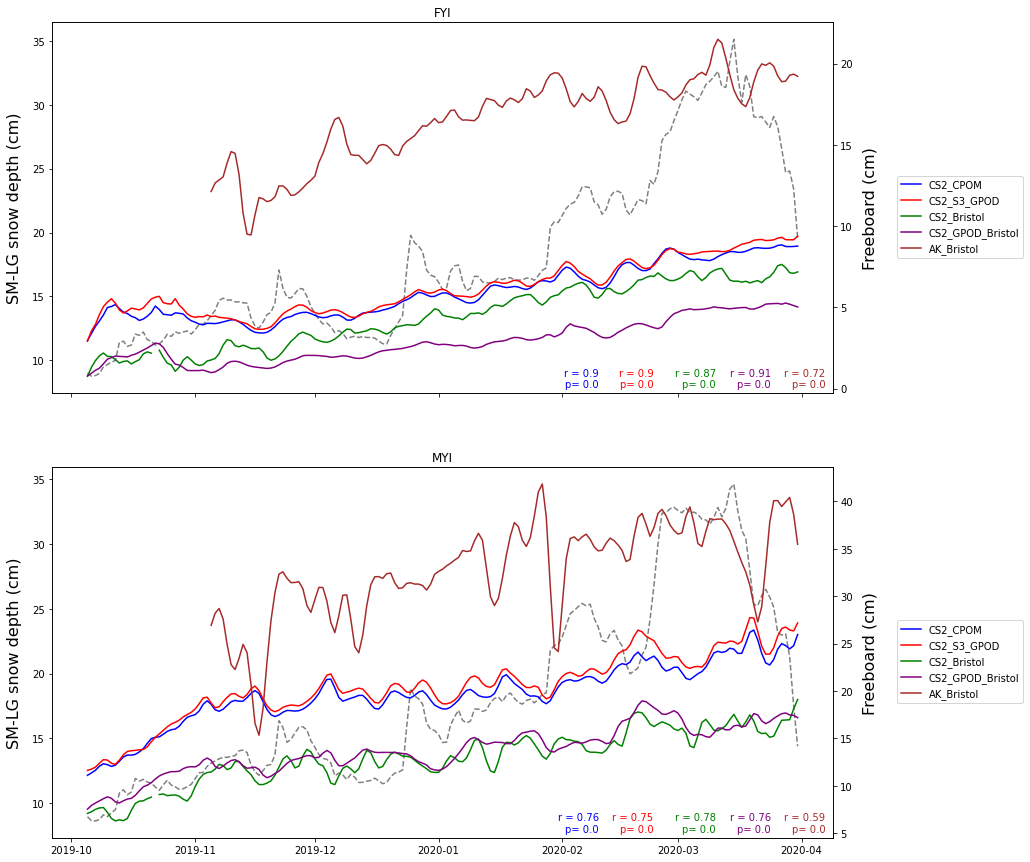

In [5]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(14,15))
titles = ['FYI','MYI']
CS2_CPOM = [CS2_CPOM_mean_FYI,CS2_CPOM_mean_MYI]
CS2_S3_GPOD = [CS2_S3_GPOD_mean_FYI,CS2_S3_GPOD_mean_MYI]
CS2_Bristol= [CS2_Bristol_mean_FYI,CS2_Bristol_mean_MYI]
CS2_GPOD_Bristol = [CS2_GPOD_Bristol_mean_FYI,CS2_GPOD_Bristol_mean_MYI]
S3_GPOD_Bristol = [S3_GPOD_Bristol_mean_FYI,S3_GPOD_Bristol_mean_MYI]
AK_Bristol = [AK_Bristol_mean_FYI,AK_Bristol_mean_MYI]
snow = [snow_mean_FYI,snow_mean_MYI]

for k in range(2):
    ax[k].plot(dates,snow[k],'k',linestyle='--',linewidth=1.5,alpha=0.5)
    ax[k].set_ylabel('SM-LG snow depth (cm)',labelpad=10,fontsize=16)
    ax2 = ax[k].twinx()
    ax2.plot(dates, CS2_CPOM[k], label ='CS2_CPOM',color='blue')
    ax2.plot(dates, CS2_S3_GPOD[k], label ='CS2_S3_GPOD',color='red')
    ax2.plot(dates, CS2_Bristol[k], label ='CS2_Bristol',color='green')
    ax2.plot(dates, CS2_GPOD_Bristol[k], label ='CS2_GPOD_Bristol',color='purple')
    ax2.plot(dates, AK_Bristol[k], label ='AK_Bristol',color='brown')
    
    # calculate stats
    for var,coords,color in zip([CS2_CPOM,CS2_S3_GPOD,CS2_Bristol,CS2_GPOD_Bristol,AK_Bristol],[0.7,0.77,0.85,0.92,0.99],['blue','red','green','purple','brown']):
        s = snow[k]
        f = var[k]
        mask = ~np.isnan(s) & ~np.isnan(f)
        rstats = pearsonr(s[mask],f[mask])
        r = np.round(rstats[0],decimals=2)
        p = np.round(rstats[1],decimals=3)
        ax2.annotate(f'r = {r}\np= {p}',xy=(coords,0.01),va='bottom',ha='right',xycoords='axes fraction',color=color)
    
    ax2.set_ylabel('Freeboard (cm)',labelpad=10,fontsize=16)
    ax2.set_title(titles[k])
    ax2.legend(bbox_to_anchor = (1.25, 0.6))
#plt.savefig('/Users/carmennab/PhD/OI_PolarSnow/figs/fig4.pdf',bbox_inches = "tight")

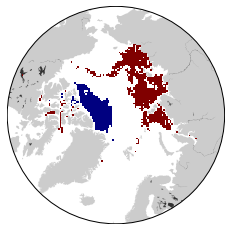

In [6]:
m = Basemap(projection='npstere',boundinglat=60,lon_0=0, resolution='l',round=True)
m.fillcontinents(color=(0.8, 0.8, 0.8),lake_color=(0.2, 0.2, 0.2))
itype_mask = np.zeros((160,160))*np.nan
itype_mask[FYI] = 1
itype_mask[MYI] = 0
m.pcolormesh(x_WG,y_WG,itype_mask,cmap='jet',vmin=0,vmax=.4,rasterized=True)

### 30-day running mean

In [7]:
def runningmean(means, T):
    r=[]
    for i in range(T):
        r.append(np.nanmean(means[0:i+T+1]))

    for i in range(T,np.size(means)-T):
        r.append(np.nanmean(means[i-T:i+T+1]))

    for i in range(np.size(means)-T,np.size(means)+1):
        r.append(np.nanmean(means[i-T:]))

    return r

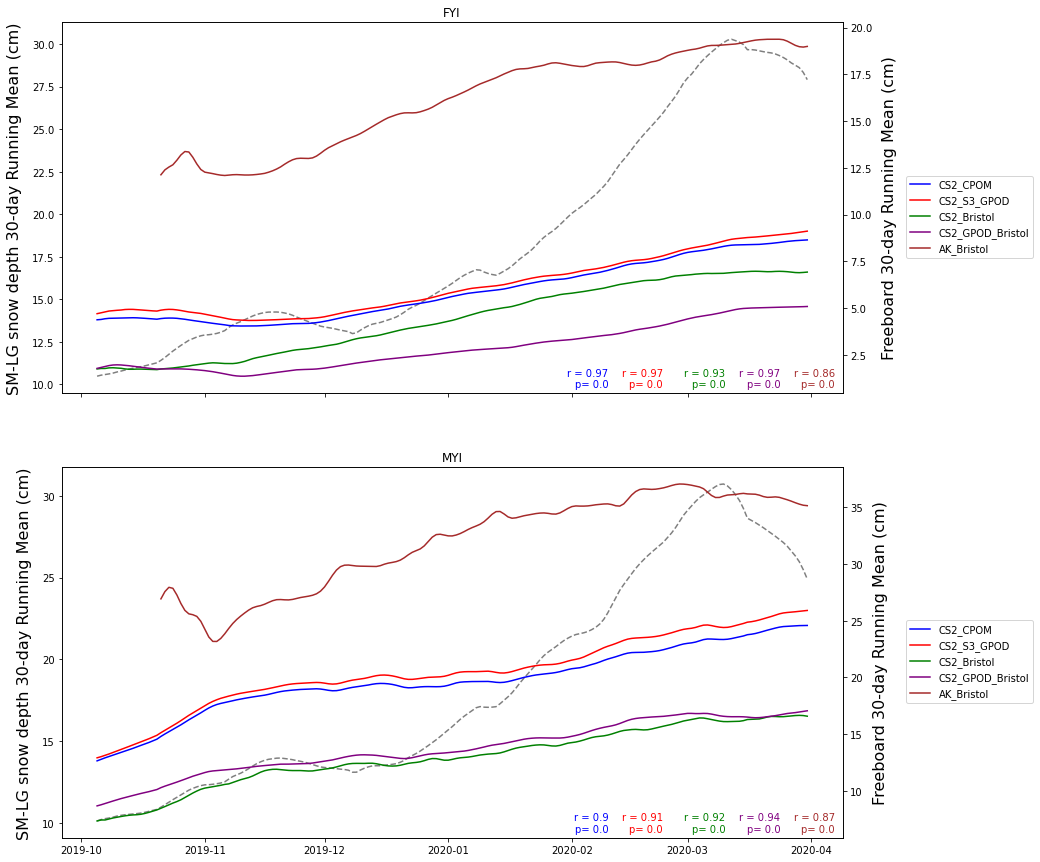

In [8]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(14,15))
titles = ['FYI','MYI']
CS2_CPOM = [runningmean(CS2_CPOM_mean_FYI,T=15),runningmean(CS2_CPOM_mean_MYI,T=15)]
CS2_S3_GPOD = [runningmean(CS2_S3_GPOD_mean_FYI,T=15),runningmean(CS2_S3_GPOD_mean_MYI,T=15)]
CS2_Bristol= [runningmean(CS2_Bristol_mean_FYI,T=15),runningmean(CS2_Bristol_mean_MYI,T=15)]
CS2_GPOD_Bristol = [runningmean(CS2_GPOD_Bristol_mean_FYI,T=15),runningmean(CS2_GPOD_Bristol_mean_MYI,T=15)]
S3_GPOD_Bristol = [runningmean(S3_GPOD_Bristol_mean_FYI,T=15),runningmean(S3_GPOD_Bristol_mean_MYI,T=15)]
AK_Bristol = [runningmean(AK_Bristol_mean_FYI,T=15),runningmean(AK_Bristol_mean_MYI,T=15)]
snow = [runningmean(snow_mean_FYI,T=15),runningmean(snow_mean_MYI,T=15)]

for k in range(2):
    ax[k].plot(dates,snow[k][:-1],'k',linestyle='--',linewidth=1.5,alpha=0.5)
    ax[k].set_ylabel('SM-LG snow depth 30-day Running Mean (cm)',labelpad=10,fontsize=16)
    ax2 = ax[k].twinx()
    ax2.plot(dates, CS2_CPOM[k][:-1], label ='CS2_CPOM',color='blue')
    ax2.plot(dates, CS2_S3_GPOD[k][:-1], label ='CS2_S3_GPOD',color='red')
    ax2.plot(dates, CS2_Bristol[k][:-1], label ='CS2_Bristol',color='green')
    ax2.plot(dates, CS2_GPOD_Bristol[k][:-1], label ='CS2_GPOD_Bristol',color='purple')
    ax2.plot(dates, AK_Bristol[k][:-1], label ='AK_Bristol',color='brown')
    
    # calculate stats
    for var,coords,color in zip([CS2_CPOM,CS2_S3_GPOD,CS2_Bristol,CS2_GPOD_Bristol,AK_Bristol],[0.7,0.77,0.85,0.92,0.99],['blue','red','green','purple','brown']):
        s = np.asarray(snow[k])
        f = np.asarray(var[k])
        mask = ~np.isnan(s) & ~np.isnan(f)
        rstats = pearsonr(s[mask],f[mask])
        r = np.round(rstats[0],decimals=2)
        p = np.round(rstats[1],decimals=3)
        ax2.annotate(f'r = {r}\np= {p}',xy=(coords,0.01),va='bottom',ha='right',xycoords='axes fraction',color=color)
    
    ax2.set_ylabel('Freeboard 30-day Running Mean (cm)',labelpad=10,fontsize=16)
    ax2.set_title(titles[k])
    ax2.legend(bbox_to_anchor = (1.25, 0.6))
#plt.savefig('/Users/carmennab/PhD/OI_PolarSnow/figs/fig4.pdf',bbox_inches = "tight")

### unsmoothed anomalies from 30-day running mean

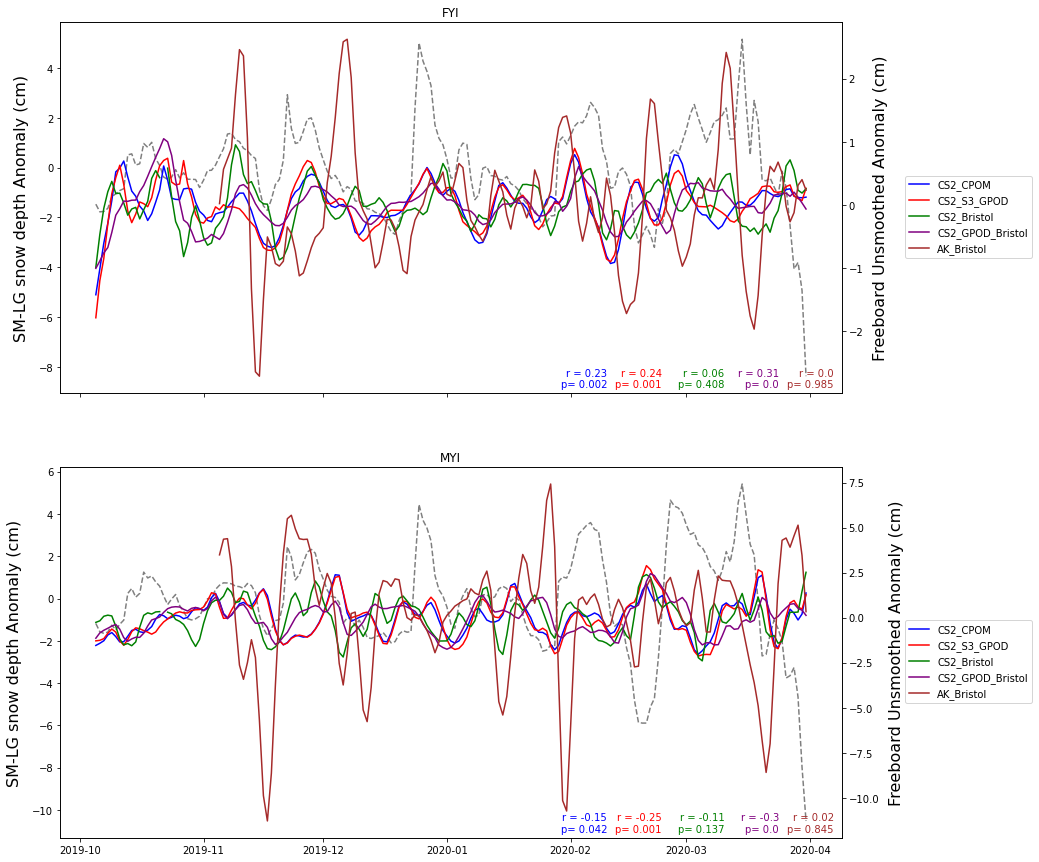

In [9]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(14,15))
titles = ['FYI','MYI']
CS2_CPOM = [runningmean(np.asarray(CS2_CPOM_mean_FYI) - np.asarray(runningmean(CS2_CPOM_mean_FYI,T=15)[:-1]), T=0),
            runningmean(np.asarray(CS2_CPOM_mean_MYI) - np.asarray(runningmean(CS2_CPOM_mean_MYI,T=15)[:-1]), T=0)]
CS2_S3_GPOD = [runningmean(np.asarray(CS2_S3_GPOD_mean_FYI) - np.asarray(runningmean(CS2_S3_GPOD_mean_FYI,T=15)[:-1]), T=0),
               runningmean(np.asarray(CS2_S3_GPOD_mean_MYI) - np.asarray(runningmean(CS2_S3_GPOD_mean_MYI,T=15)[:-1]), T=0)]
CS2_Bristol= [runningmean(np.asarray(CS2_Bristol_mean_FYI) - np.asarray(runningmean(CS2_Bristol_mean_FYI,T=15)[:-1]), T=0),
              runningmean(np.asarray(CS2_Bristol_mean_MYI) - np.asarray(runningmean(CS2_Bristol_mean_MYI,T=15)[:-1]), T=0)]
CS2_GPOD_Bristol = [runningmean(np.asarray(CS2_GPOD_Bristol_mean_FYI) - np.asarray(runningmean(CS2_GPOD_Bristol_mean_FYI,T=15)[:-1]), T=0),
                    runningmean(np.asarray(CS2_GPOD_Bristol_mean_MYI) - np.asarray(runningmean(CS2_GPOD_Bristol_mean_MYI,T=15)[:-1]), T=0)]
S3_GPOD_Bristol = [runningmean(np.asarray(S3_GPOD_Bristol_mean_FYI) - np.asarray(runningmean(S3_GPOD_Bristol_mean_FYI,T=15)[:-1]), T=0),
                   runningmean(np.asarray(S3_GPOD_Bristol_mean_MYI) - np.asarray(runningmean(S3_GPOD_Bristol_mean_MYI,T=15)[:-1]), T=0)]
AK_Bristol = [runningmean(np.asarray(AK_Bristol_mean_FYI) - np.asarray(runningmean(AK_Bristol_mean_FYI,T=15)[:-1]), T=0),
                   runningmean(np.asarray(AK_Bristol_mean_MYI) - np.asarray(runningmean(AK_Bristol_mean_MYI,T=15)[:-1]), T=0)]
snow = [runningmean(np.asarray(snow_mean_FYI) - np.asarray(runningmean(snow_mean_FYI,T=15)[:-1]), T=0),
        runningmean(np.asarray(snow_mean_MYI) - np.asarray(runningmean(snow_mean_MYI,T=15)[:-1]), T=0)]

for k in range(2):
    ax[k].plot(dates,snow[k][:-1],'k',linestyle='--',linewidth=1.5,alpha=0.5)
    ax[k].set_ylabel('SM-LG snow depth Anomaly (cm)',labelpad=10,fontsize=16)
    ax2 = ax[k].twinx()
    ax2.plot(dates, CS2_CPOM[k][:-1], label ='CS2_CPOM',color='blue')
    ax2.plot(dates, CS2_S3_GPOD[k][:-1], label ='CS2_S3_GPOD',color='red')
    ax2.plot(dates, CS2_Bristol[k][:-1], label ='CS2_Bristol',color='green')
    ax2.plot(dates, CS2_GPOD_Bristol[k][:-1], label ='CS2_GPOD_Bristol',color='purple')
    ax2.plot(dates, AK_Bristol[k][:-1], label ='AK_Bristol',color='brown')
    
    # calculate stats
    for var,coords,color in zip([CS2_CPOM,CS2_S3_GPOD,CS2_Bristol,CS2_GPOD_Bristol,AK_Bristol],[0.7,0.77,0.85,0.92,0.99],['blue','red','green','purple','brown']):
        s = np.asarray(snow[k])
        f = np.asarray(var[k])
        mask = ~np.isnan(s) & ~np.isnan(f)
        rstats = pearsonr(s[mask],f[mask])
        r = np.round(rstats[0],decimals=2)
        p = np.round(rstats[1],decimals=3)
        ax2.annotate(f'r = {r}\np= {p}',xy=(coords,0.01),va='bottom',ha='right',xycoords='axes fraction',color=color)
    
    ax2.set_ylabel('Freeboard Unsmoothed Anomaly (cm)',labelpad=10,fontsize=16)
    ax2.set_title(titles[k])
    ax2.legend(bbox_to_anchor = (1.25, 0.6))
#plt.savefig('/Users/carmennab/PhD/OI_PolarSnow/figs/fig4.pdf',bbox_inches = "tight")

### smoothed anomalies from 30-day running mean

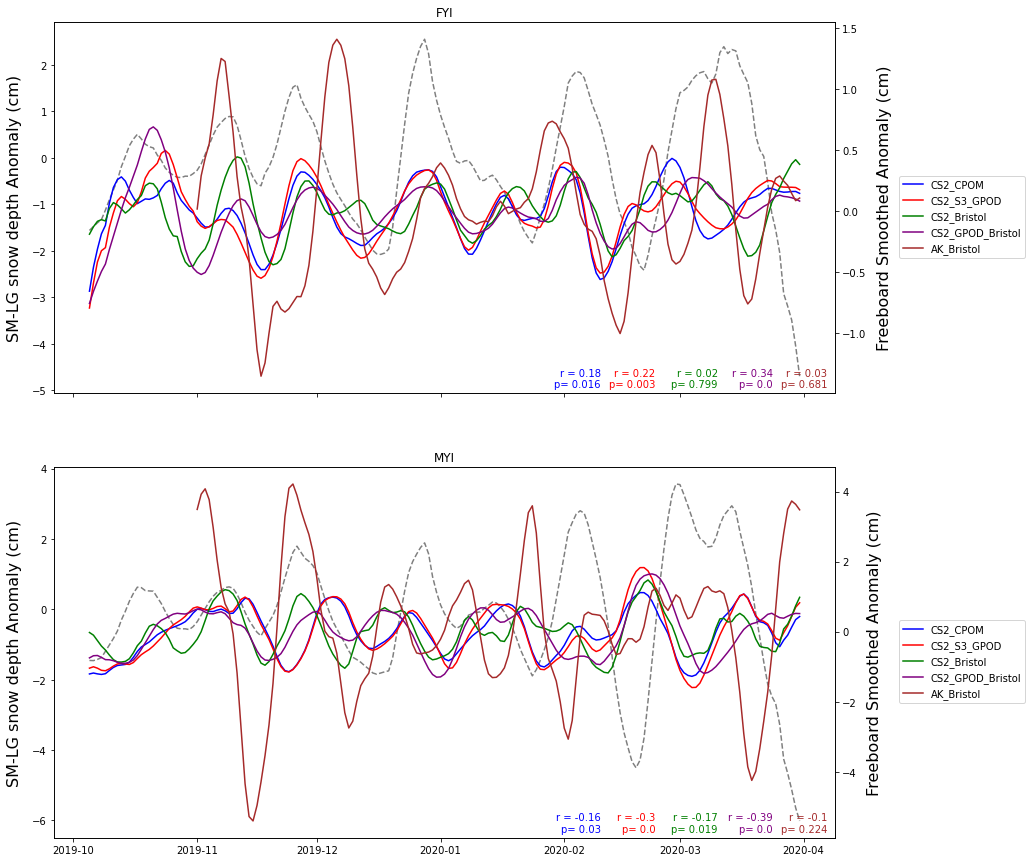

In [10]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(14,15))
titles = ['FYI','MYI']
CS2_CPOM = [runningmean(np.asarray(CS2_CPOM_mean_FYI) - np.asarray(runningmean(CS2_CPOM_mean_FYI,T=15)[:-1]), T=4),
            runningmean(np.asarray(CS2_CPOM_mean_MYI) - np.asarray(runningmean(CS2_CPOM_mean_MYI,T=15)[:-1]), T=4)]
CS2_S3_GPOD = [runningmean(np.asarray(CS2_S3_GPOD_mean_FYI) - np.asarray(runningmean(CS2_S3_GPOD_mean_FYI,T=15)[:-1]), T=4),
               runningmean(np.asarray(CS2_S3_GPOD_mean_MYI) - np.asarray(runningmean(CS2_S3_GPOD_mean_MYI,T=15)[:-1]), T=4)]
CS2_Bristol= [runningmean(np.asarray(CS2_Bristol_mean_FYI) - np.asarray(runningmean(CS2_Bristol_mean_FYI,T=15)[:-1]), T=4),
              runningmean(np.asarray(CS2_Bristol_mean_MYI) - np.asarray(runningmean(CS2_Bristol_mean_MYI,T=15)[:-1]), T=4)]
CS2_GPOD_Bristol = [runningmean(np.asarray(CS2_GPOD_Bristol_mean_FYI) - np.asarray(runningmean(CS2_GPOD_Bristol_mean_FYI,T=15)[:-1]), T=4),
                    runningmean(np.asarray(CS2_GPOD_Bristol_mean_MYI) - np.asarray(runningmean(CS2_GPOD_Bristol_mean_MYI,T=15)[:-1]), T=4)]
S3_GPOD_Bristol = [runningmean(np.asarray(S3_GPOD_Bristol_mean_FYI) - np.asarray(runningmean(S3_GPOD_Bristol_mean_FYI,T=15)[:-1]), T=4),
                   runningmean(np.asarray(S3_GPOD_Bristol_mean_MYI) - np.asarray(runningmean(S3_GPOD_Bristol_mean_MYI,T=15)[:-1]), T=4)]
AK_Bristol = [runningmean(np.asarray(AK_Bristol_mean_FYI) - np.asarray(runningmean(AK_Bristol_mean_FYI,T=15)[:-1]), T=4),
                   runningmean(np.asarray(AK_Bristol_mean_MYI) - np.asarray(runningmean(AK_Bristol_mean_MYI,T=15)[:-1]), T=4)]
snow = [runningmean(np.asarray(snow_mean_FYI) - np.asarray(runningmean(snow_mean_FYI,T=15)[:-1]), T=4),
        runningmean(np.asarray(snow_mean_MYI) - np.asarray(runningmean(snow_mean_MYI,T=15)[:-1]), T=4)]

for k in range(2):
    ax[k].plot(dates,snow[k][:-1],'k',linestyle='--',linewidth=1.5,alpha=0.5)
    ax[k].set_ylabel('SM-LG snow depth Anomaly (cm)',labelpad=10,fontsize=16)
    ax2 = ax[k].twinx()
    ax2.plot(dates, CS2_CPOM[k][:-1], label ='CS2_CPOM',color='blue')
    ax2.plot(dates, CS2_S3_GPOD[k][:-1], label ='CS2_S3_GPOD',color='red')
    ax2.plot(dates, CS2_Bristol[k][:-1], label ='CS2_Bristol',color='green')
    ax2.plot(dates, CS2_GPOD_Bristol[k][:-1], label ='CS2_GPOD_Bristol',color='purple')
    ax2.plot(dates, AK_Bristol[k][:-1], label ='AK_Bristol',color='brown')
    
    # calculate stats
    for var,coords,color in zip([CS2_CPOM,CS2_S3_GPOD,CS2_Bristol,CS2_GPOD_Bristol,AK_Bristol],[0.7,0.77,0.85,0.92,0.99],['blue','red','green','purple','brown']):
        s = np.asarray(snow[k])
        f = np.asarray(var[k])
        mask = ~np.isnan(s) & ~np.isnan(f)
        rstats = pearsonr(s[mask],f[mask])
        r = np.round(rstats[0],decimals=2)
        p = np.round(rstats[1],decimals=3)
        ax2.annotate(f'r = {r}\np= {p}',xy=(coords,0.01),va='bottom',ha='right',xycoords='axes fraction',color=color)
    
    ax2.set_ylabel('Freeboard Smoothed Anomaly (cm)',labelpad=10,fontsize=16)
    ax2.set_title(titles[k])
    ax2.legend(bbox_to_anchor = (1.25, 0.6))
#plt.savefig('/Users/carmennab/PhD/OI_PolarSnow/figs/fig4.pdf',bbox_inches = "tight")